## Chronos Finetuned Q



In [ ]:
!pip install chronos-forecasting

In [ ]:
import pandas as pd
from chronos import BaseChronosPipeline

pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-2", device_map="cuda")



Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416
Columns (DF_d): ['EUR_NOK', 'd_pi', 'dI_t', 'Q']

Fine-tune panel: 1980-12-10 → 1999-12-31 | n=4930
Fine-tune FX columns: ['AUD', 'CAD', 'CHF', 'DKK', 'GBP', 'ISK', 'JPY', 'NZD', 'SEK', 'USD', 'XDR']

[Fine-tuning Chronos-2 on Norges Bank FX panel 1980–1999]
  Number of series: 11
  Total length across series: 52815
  Using prediction_length=32, num_steps=50, lr=1e-05, batch_size=2


/tmp/ipython-input-1534054343.py:213: FutureWarning: Fine-tuning support is experimental and may be changed in future versions.
  pipeline = pipeline.fit(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,2.024800
20,2.704700
30,1.760400
40,1.748100
50,1.498000



Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

=== Model performance (quarterly mean, EUR/NOK – past macro covariates, finetuned) ===
Observations: 103
RMSE (level): 0.196325
MAE  (level): 0.136837
Directional accuracy: 79/102 (77.5%)

=== Diebold–Mariano vs Random Walk (past macro covariates, quarterly, finetuned) ===
Loss: MSE | horizon h=1
DM-statistic: -2.1941
p-value     : 0.0282


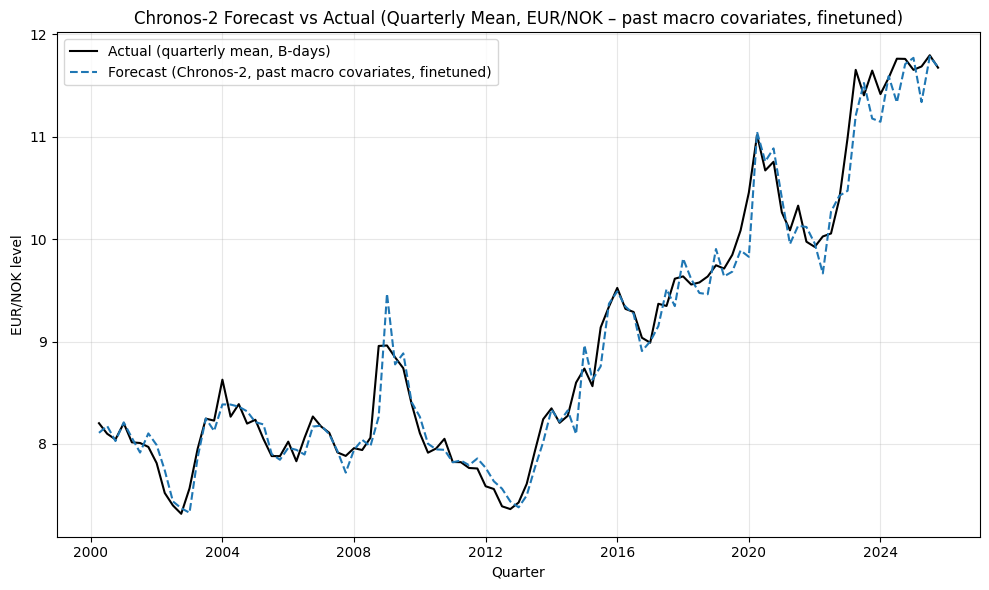

Saved: Chronos2Q_daily_pastcov_finetuned.png
Saved: Chronos2Q_daily_pastcov_finetuned.pdf


In [6]:
# -*- coding: utf-8 -*-
"""
Chronos-2 – EUR/NOK walk-forward (quarterly, levels) with daily macro covariates
+ optional fine-tuning on Norges Bank FX panel (1980–1999).

Evaluation setup (univariate target with past-only macros):
  - Target: EUR_NOK (single series)
  - Macros: Q, d_pi, dI_t as past-only covariates
  - Data: daily (calendar days), forward-filled
  - Cut: last business day of previous quarter (based on EUR_NOK B-days)
  - Forecast: next calendar quarter at daily frequency,
              aggregated to quarterly mean over business days (EUR/NOK)
  - No future_df passed to Chronos-2 -> no leakage from future macro paths

Fine-tuning setup:
  - Dataset: Norges Bank FX panel 1980–1999 (NB1980-1999.csv)
  - FX columns (11 series): AUD, CAD, CHF, DKK, GBP, ISK, JPY, NZD, SEK, USD, XDR
  - Each FX series is treated as a separate univariate item (price-only, no covariates).
"""

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Callable, List

import numpy as np
import pandas as pd
import requests, certifi
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

import torch
from chronos import BaseChronosPipeline  # chronos-forecasting>=2.0

# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url_daily: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    url_finetune: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/FineTuneData/NB1980-1999.csv"
    )
    q_freq: str = "Q"         # quarterly evaluation (Q-DEC)
    min_hist_days: int = 40   # minimum number of daily obs before first forecast
    max_context: int = 2048
    max_horizon: int = 100    # longest quarter ~92 days; 100 er trygg margin
    retries: int = 3
    timeout: int = 60
    verbose: bool = True
    fig_png: str = "Chronos2Q_daily_pastcov_finetuned.png"
    fig_pdf: str = "Chronos2Q_daily_pastcov_finetuned.pdf"

    # Fine-tuning hyperparameters (konservative)
    ft_prediction_length: int = 32
    ft_num_steps: int = 50
    ft_learning_rate: float = 1e-5
    ft_batch_size: int = 2
    ft_logging_steps: int = 10

CFG = Config()

TARGET_SERIES = "EUR_NOK"
MACRO_COLS = ["Q", "d_pi", "dI_t"]

FINETUNE_FX_COLS = [
    "AUD", "CAD", "CHF", "DKK", "GBP",
    "ISK", "JPY", "NZD", "SEK", "USD", "XDR",
]

# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")

# -----------------------------
# Data loading: daily EUR_NOK (B + D) + macro covariates
# -----------------------------
def load_series(url: str) -> Tuple[pd.Series, pd.DataFrame]:
    """
    CSV columns expected: Date, EUR_NOK, Q, d_pi, dI_t

    Returns:
      S_b  : EUR_NOK on business days (B) ffill (for cuts and quarterly ground truth)
      DF_d : daily (D) DataFrame with columns [EUR_NOK, Q, d_pi, dI_t] (calendar days, ffill)
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required_cols = {"Date", "EUR_NOK", "Q", "d_pi", "dI_t"}
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[list(required_cols)]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", "EUR_NOK"])
        .sort_values("DATE")
        .set_index("DATE")
    )

    for col in ["EUR_NOK"] + MACRO_COLS:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=["EUR_NOK"])

    # Business-day EUR_NOK
    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    # Daily calendar, ffill
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d

def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None

# -----------------------------
# Fine-tune panel loader (1980–1999)
# -----------------------------
def load_finetune_fx_panel(url: str) -> pd.DataFrame:
    """
    CSV format: ds;AUD;CAD;CHF;DKK;GBP;ISK;JPY;NZD;SEK;USD;XDR
    Returns daily df indexed by DATE with float columns for the 11 FX series.
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text), sep=";", decimal=".", encoding="utf-8-sig")

    required = ["ds"] + FINETUNE_FX_COLS
    missing = set(required) - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in fine-tune CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[required]
        .rename(columns={"ds": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], dayfirst=True, errors="coerce"))
        .dropna(subset=["DATE"])
        .sort_values("DATE")
        .set_index("DATE")
    )
    for col in FINETUNE_FX_COLS:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(how="all", subset=FINETUNE_FX_COLS)
    return df

# -----------------------------
# Chronos-2: base + fine-tuning
# -----------------------------
def build_base_chronos_pipeline() -> BaseChronosPipeline:
    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available. Install CUDA-enabled PyTorch and a recent NVIDIA driver.")
    pipeline: BaseChronosPipeline = BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        torch_dtype=torch.float16,
    )
    return pipeline

def finetune_chronos_on_nb_panel(
    pipeline: BaseChronosPipeline,
    fx_panel: pd.DataFrame,
) -> BaseChronosPipeline:
    """
    Price-only finetuning: each FX column is a separate univariate item.
    """
    train_inputs: List[Dict] = []
    for col in FINETUNE_FX_COLS:
        series = fx_panel[col].dropna().astype(np.float32).values
        if series.size < CFG.ft_prediction_length * 2:
            continue
        train_inputs.append({
            "target": series,
            "past_covariates": {},
            "future_covariates": {},
        })

    if not train_inputs:
        raise RuntimeError("No valid series found for fine-tuning.")

    if CFG.verbose:
        total_len = sum(len(d["target"]) for d in train_inputs)
        print("\n[Fine-tuning Chronos-2 on Norges Bank FX panel 1980–1999]")
        print(f"  Number of series: {len(train_inputs)}")  # should be 11
        print(f"  Total length across series: {total_len}")
        print(f"  Using prediction_length={CFG.ft_prediction_length}, "
              f"num_steps={CFG.ft_num_steps}, lr={CFG.ft_learning_rate}, "
              f"batch_size={CFG.ft_batch_size}")

    # Fine-tune (Chronos warning: experimental API)
    pipeline = pipeline.fit(
        inputs=train_inputs,
        prediction_length=CFG.ft_prediction_length,
        num_steps=CFG.ft_num_steps,
        learning_rate=CFG.ft_learning_rate,
        batch_size=CFG.ft_batch_size,
        logging_steps=CFG.ft_logging_steps,
    )
    return pipeline

# -----------------------------
# Chronos-2 predictor (univariate + past-only macro covariates)
# -----------------------------
def build_model_chronos2(
    pipeline: BaseChronosPipeline,
    max_context: int,
    horizon_len: int,
) -> Callable[[pd.DataFrame, int], np.ndarray]:

    def _extract_median(pred: pd.DataFrame) -> np.ndarray:
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values("timestamp")
        if "0.5" in df.columns:
            y = df["0.5"].to_numpy()
        elif "predictions" in df.columns:
            y = df["predictions"].to_numpy()
        elif {"forecast", "quantile"}.issubset(df.columns):
            y = df.loc[df["quantile"] == 0.5, "forecast"].to_numpy()
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    y = df[cand].to_numpy()
                    break
            else:
                raise RuntimeError(f"Unsupported Chronos schema: {list(df.columns)}")
        return np.asarray(y, dtype=float)

    def _forecast(hist_df: pd.DataFrame, H: int) -> np.ndarray:
        ctx = hist_df.tail(max_context).copy()
        df_ctx = ctx.reset_index().rename(columns={"DATE": "timestamp", "EUR_NOK": "target"})
        df_ctx["item_id"] = "EUR_NOK"
        cols = ["item_id", "timestamp", "target"] + MACRO_COLS
        df_ctx = df_ctx[cols]
        with torch.inference_mode():
            pred = pipeline.predict_df(
                df_ctx,
                prediction_length=H,
                quantile_levels=[0.5],
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
                # No future_df -> macros treated as past covariates only
            )
        med = _extract_median(pred)
        return med[:H]

    return _forecast

# -----------------------------
# Quarterly walk-forward with past macro covariates
# -----------------------------
def walk_forward_chronos2_quarterly_pastcov(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], np.ndarray],
) -> pd.DataFrame:
    """
    Quarterly walk-forward based on daily EUR_NOK forecasts with macro covariates.

    For each calendar quarter q:
      - Cut at last business day of previous quarter (based on S_b).
      - Use daily history up to and including cut (DF_d) as input.
      - Forecast the full next calendar quarter at daily frequency.
      - Aggregate forecasts to business-day quarterly mean.
      - Compare with actual quarterly mean from S_b.
    """
    first_q = pd.Period(S_b.index.min(), freq=CFG.q_freq)
    last_q  = pd.Period(S_b.index.max(),  freq=CFG.q_freq)
    quarters = pd.period_range(first_q, last_q, freq=CFG.q_freq)

    rows: Dict = {}
    dropped: Dict[str, str] = {}

    for q in quarters:
        prev_q = q - 1
        q_start, q_end = q.start_time, q.end_time
        prev_start, prev_end = prev_q.start_time, prev_q.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(q)] = "no_cut_in_prev_quarter"
            continue

        hist_df = DF_d.loc[:cut]
        if hist_df.shape[0] < CFG.min_hist_days:
            dropped[str(q)] = f"hist<{CFG.min_hist_days}"
            continue

        # Business days inside target quarter
        idx_q_b = S_b.index[(S_b.index >= q_start) & (S_b.index <= q_end)]
        if idx_q_b.size < 1:
            dropped[str(q)] = "no_bdays_in_quarter"
            continue
        y_true = float(S_b.loc[idx_q_b].mean())

        # Horizon = number of calendar days in quarter
        H = (q_end.date() - q_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            dropped[str(q)] = f"horizon_invalid(H={H})"
            continue

        pf = forecast_fn(hist_df, H)
        if pf.shape[0] < H:
            dropped[str(q)] = f"horizon_short({pf.shape[0]})"
            continue

        # Daily forecast index from cut+1 for H days
        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        pred_daily = pd.Series(pf[:H], index=f_idx, name="point")

        # Aggregate to business-day mean over the quarter
        pred_b = pred_daily.reindex(idx_q_b, method=None)
        if pred_b.isna().all():
            dropped[str(q)] = "no_overlap_pred_B_days"
            continue
        y_pred = float(pred_b.dropna().mean())

        rows[str(q)] = {"quarter": q, "cut": cut, "y_true": y_true, "y_pred": y_pred}

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("quarter").sort_index()

    if CFG.verbose and dropped:
        miss = [str(q) for q in quarters if q not in df.index]
        if miss:
            print("\nDropped quarters and reasons:")
            for qq in miss:
                print(f"  {qq}: {dropped.get(qq, 'unknown')}")
    return df

# -----------------------------
# Evaluation (level + direction)
# -----------------------------
def evaluate_quarterly(eval_df: pd.DataFrame) -> pd.DataFrame:
    """Compute level errors and directional accuracy (QoQ)."""
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    # Directional accuracy vs previous quarter
    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    print("\n=== Model performance (quarterly mean, EUR/NOK – past macro covariates, finetuned) ===")
    print(f"Observations: {n_obs}")
    print(f"RMSE (level): {rmse:.6f}")
    print(f"MAE  (level): {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core

# -----------------------------
# Diebold–Mariano (vs Random Walk) – quarterly
# -----------------------------
def _normal_cdf(z: float) -> float:
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))

def dm_test(
    y_true: pd.Series,
    y_model: pd.Series,
    y_rw: pd.Series,
    h: int = 1,
    loss: str = "mse",
) -> Tuple[float, float]:
    """
    DM test with simple Bartlett HAC up to lag h-1.
    """
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val

def dm_against_random_walk_quarterly(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1) -> None:
    """
    Random walk benchmark (quarterly): previous quarter's observed level.
    """
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)
    print("\n=== Diebold–Mariano vs Random Walk (past macro covariates, quarterly, finetuned) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value: nan")

# -----------------------------
# Plot (quarterly)
# -----------------------------
def plot_quarterly_simple(eval_df: pd.DataFrame, png_path: str, pdf_path: str):
    """Line plot: actual vs forecast (quarterly mean, EUR/NOK)."""
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (quarterly mean, B-days)")
    plt.plot(
        x, eval_df["y_pred"], color="tab:blue", linestyle="--",
        label="Forecast (Chronos-2, past macro covariates, finetuned)"
    )

    plt.title("Chronos-2 Forecast vs Actual (Quarterly Mean, EUR/NOK – past macro covariates, finetuned)")
    plt.xlabel("Quarter")
    plt.ylabel("EUR/NOK level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()
    print(f"Saved: {png_path}")
    print(f"Saved: {pdf_path}")

# -----------------------------
# Main
# -----------------------------
def main():
    # 1) Load evaluation data
    S_b, DF_d = load_series(CFG.url_daily)
    if CFG.verbose:
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {DF_d.index.min().date()} → {DF_d.index.max().date()} | n={len(DF_d)}")
        print(f"Columns (DF_d): {list(DF_d.columns)}")

    # 2) Load fine-tune panel (11 FX serier, 1980–1999)
    fx_panel = load_finetune_fx_panel(CFG.url_finetune)
    if CFG.verbose:
        print(f"\nFine-tune panel: {fx_panel.index.min().date()} → {fx_panel.index.max().date()} | n={len(fx_panel)}")
        print(f"Fine-tune FX columns: {FINETUNE_FX_COLS}")

    # 3) Build base Chronos-2 pipeline and fine-tune
    base_pipeline = build_base_chronos_pipeline()
    ft_pipeline = finetune_chronos_on_nb_panel(base_pipeline, fx_panel)

    # 4) Build forecasting function using the finetuned pipeline
    forecast_fn = build_model_chronos2(
        pipeline=ft_pipeline,
        max_context=CFG.max_context,
        horizon_len=min(CFG.max_horizon, 100),
    )

    # 5) Quarterly walk-forward and evaluation
    df_eval = walk_forward_chronos2_quarterly_pastcov(S_b, DF_d, forecast_fn)
    eval_df = evaluate_quarterly(df_eval)

    # 6) Diebold–Mariano vs Random Walk (MSE; h=1)
    dm_against_random_walk_quarterly(eval_df, loss="mse", h=1)

    # 7) Plot results
    plot_quarterly_simple(eval_df, CFG.fig_png, CFG.fig_pdf)

if __name__ == "__main__":
    main()
